# Image Caption Generator using CNN-LSTM
## Step-by-step implementation with Flickr8k dataset

In [ ]:
# Cell 1: Download datasets
!wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
!wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip

--2025-10-16 12:44:27--  https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
Resolving github.com (github.com)... 140.82.116.4
Connecting to github.com (github.com)|140.82.116.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/124585957/47f52b80-3501-11e9-8f49-4515a2a3339b?sp=r&sv=2018-11-09&sr=b&spr=https&se=2025-10-16T13%3A26%3A34Z&rscd=attachment%3B+filename%3DFlickr8k_Dataset.zip&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&skt=2025-10-16T12%3A26%3A25Z&ske=2025-10-16T13%3A26%3A34Z&sks=b&skv=2018-11-09&sig=c2k744oeb0Ch85cWcdiH%2F9pZFW2%2FzaXkTiRUJxoDGZY%3D&jwt=eyJ0eXAiOiJKV1QiLCJhbGciOiJIUzI1NiJ9.eyJpc3MiOiJnaXRodWIuY29tIiwiYXVkIjoicmVsZWFzZS1hc3NldHMuZ2l0aHVidXNlcmNvbnRlbnQuY29tIiwia2V5Ijoia2V5MSIsImV4cCI6MTc2MDYyMjI1NSwibmJmIjoxNzYwNjE4NjU1LCJwYXRoIjoicmVsZWFzZWFzc2V0cHJ

In [ ]:
# Cell 2: Extract datasets
import zipfile
import os

with zipfile.ZipFile('Flickr8k_Dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

with zipfile.ZipFile('Flickr8k_text.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

In [ ]:
# Cell 3: Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, Input, add
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import pickle

In [ ]:
# Cell 4: Load and preprocess captions
def load_captions(filename):
    captions = {}
    with open(filename, 'r') as file:
        for line in file:
            tokens = line.strip().split('\t')
            if len(tokens) < 2:
                continue
            image_id = tokens[0].split('.')[0]
            caption = tokens[1]
            if image_id not in captions:
                captions[image_id] = []
            captions[image_id].append(caption)
    return captions

captions = load_captions('Flickr8k.token.txt')
print(f"Loaded captions for {len(captions)} images")

Loaded captions for 8092 images


In [ ]:
# Cell 5: Clean captions
import re

def clean_captions(captions):
    cleaned = {}
    for image_id, caption_list in captions.items():
        cleaned[image_id] = []
        for caption in caption_list:
            caption = caption.lower()
            caption = re.sub(r'[^a-zA-Z0-9\s]', '', caption)
            caption = 'startseq ' + caption + ' endseq'
            cleaned[image_id].append(caption)
    return cleaned

captions = clean_captions(captions)
print("Sample caption:", list(captions.values())[0][0])

Sample caption: startseq a child in a pink dress is climbing up a set of stairs in an entry way  endseq


In [ ]:
# Cell 6: Extract features from subset of images (first 20000 for faster training)
def extract_features(directory, limit=20000):
    model = VGG16()
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

    features = {}
    count = 0
    for filename in os.listdir(directory):
        if filename.endswith('.jpg') and count < limit:
            image_path = os.path.join(directory, filename)
            image = Image.open(image_path).convert('RGB')
            image = image.resize((224, 224))
            image = np.array(image)
            image = np.expand_dims(image, axis=0)
            image = tf.keras.applications.vgg16.preprocess_input(image)

            feature = model.predict(image, verbose=0)
            image_id = filename.split('.')[0]
            features[image_id] = feature
            count += 1

    return features

print("Extracting features from first 20000 images...")
features = extract_features('Flicker8k_Dataset', limit=1000)
print(f"Extracted features for {len(features)} images")

Extracting features from first 20000 images...
Extracted features for 1000 images


In [ ]:
# Cell 7: Create vocabulary from subset captions
subset_captions = {k: v for k, v in captions.items() if k in features}
all_captions = []
for caption_list in subset_captions.values():
    all_captions.extend(caption_list)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in all_captions)

print(f"Vocabulary size: {vocab_size}")
print(f"Maximum caption length: {max_length}")

Vocabulary size: 3237
Maximum caption length: 38


In [ ]:
# Cell 8: Create training data from subset
def create_sequences(tokenizer, max_length, captions, features):
    X1, X2, y = [], [], []

    for image_id, caption_list in captions.items():
        if image_id not in features:
            continue

        for caption in caption_list:
            seq = tokenizer.texts_to_sequences([caption])[0]

            for i in range(1, len(seq)):
                in_seq, out_seq = seq[:i], seq[i]
                in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                X1.append(features[image_id][0])
                X2.append(in_seq)
                y.append(out_seq)

    return np.array(X1), np.array(X2), np.array(y)

X1, X2, y = create_sequences(tokenizer, max_length, subset_captions, features)
print(f"Training data shape: X1={X1.shape}, X2={X2.shape}, y={y.shape}")

Training data shape: X1=(58269, 4096), X2=(58269, 38), y=(58269, 3237)


In [ ]:
# Cell 9: Build the model
def create_model(vocab_size, max_length):
    # Image feature extractor
    inputs1 = Input(shape=(4096,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    # Sequence processor
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256, use_cudnn=False)(se2) # Disable cuDNN

    # Decoder
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    return model

model = create_model(vocab_size, max_length)
#model.summary()

In [ ]:
# Cell 10: Train the model (reduced epochs for faster training)
model.fit([X1, X2], y, epochs=10, batch_size=64, verbose=1)
model.save('caption_model.h5')
print("Model training completed and saved!")

In [ ]:
# Cell 11: Caption generation function
def generate_caption(model, tokenizer, photo, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = tokenizer.index_word.get(yhat)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'endseq':
            break
    return in_text.replace('startseq ', '').replace(' endseq', '')

print("Caption generation function ready!")

Caption generation function ready!


Generated caption: a man in a red shirt is walking on a field

Original captions:
- startseq a dog is jumping up at a man wearing a search and rescue jacket  endseq
- startseq a large  black dog is practicing attacking a culprit on a uniformed man  endseq
- startseq a man in a uniform playing with a black dog  endseq
- startseq a man in blue with a black hat with a dog leaping at him in a parklike setting  endseq
- startseq man in blue padded suit training a black dog for search and rescue in a field  endseq


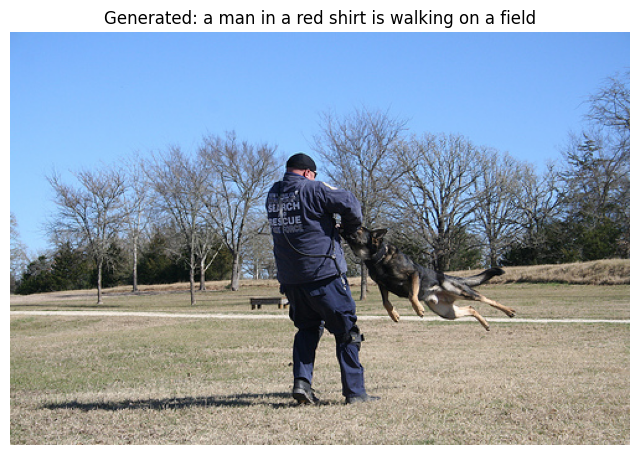

In [ ]:
# Cell 12: Test the model
# Get a random image for testing
test_image_id = list(features.keys())[0]
test_feature = features[test_image_id].reshape(1, -1)

# Generate caption
generated_caption = generate_caption(model, tokenizer, test_feature, max_length)
print(f"Generated caption: {generated_caption}")

# Show original captions for comparison
if test_image_id in captions:
    print("\nOriginal captions:")
    for caption in captions[test_image_id]:
        print(f"- {caption}")

# Display the image
image_path = f'Flicker8k_Dataset/{test_image_id}.jpg'
if os.path.exists(image_path):
    img = Image.open(image_path)
    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.title(f"Generated: {generated_caption}")
    plt.axis('off')
    plt.show()

In [ ]:
# Cell 13: Upload and test your own image
from google.colab import files

# Upload image
uploaded = files.upload()

# Process uploaded image
for filename in uploaded.keys():
    # Load VGG16 model for feature extraction
    vgg_model = VGG16()
    vgg_model = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)

    # Extract features from uploaded image
    image = Image.open(filename).convert('RGB')
    image = image.resize((224, 224))
    image = np.array(image)
    image = np.expand_dims(image, axis=0)
    image = tf.keras.applications.vgg16.preprocess_input(image)

    photo_feature = vgg_model.predict(image, verbose=0)

    # Generate caption
    caption = generate_caption(model, tokenizer, photo_feature, max_length)

    # Display result
    img = Image.open(filename)
    plt.figure(figsize=(10, 6))
    plt.imshow(img)
    plt.title(f"Generated Caption: {caption}", fontsize=16)
    plt.axis('off')
    plt.show()
    print(f"Caption: {caption}")